In [2]:
import datetime
from os import path
import math
import collections
import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as signal
import core as co
import hist_data as hd

In [3]:
import hist_data as hd

hd.set_hist_data(data_count=None)


Test data size (flats are duducted) is 677512
Test data start time is 2023:01:03 21:34
Test data end time is   2024:10:25 19:00
Subtracting moving avarage: True


forecast:
direction: buy-sell
min profit [PIP]: 7.51
panic value [PIP]: -1.46 - no panic



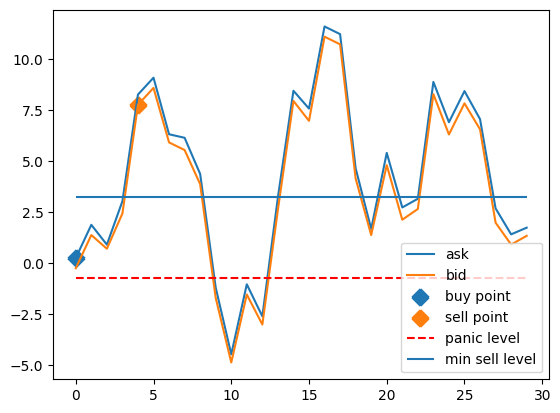

In [8]:
import importlib
import tokenizer as to
import forecast as fo
importlib.reload(fo)
import piecewise_fit as ls
importlib.reload(ls)
importlib.reload(co)

FORECAST_WINDOW = 30
FORECAST_THRESHOLD = 2e-4 + 1e-4 # spread

shift = 1000 # 1400 1500
forecast = fo.Forecast(
    hd.DATA[shift: FORECAST_WINDOW + shift], 
    threshold=FORECAST_THRESHOLD)
print(forecast)
forecast.plot(True)
# [0.000114, 0.000227, 0.000455, 0.00091, 0.00182, 0.00364, 0.00728, 0.0146]
